In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
import geopandas as gpd
import openpyxl
import seaborn as sns
import time

In [15]:
data = pd.read_csv('https://raw.githubusercontent.com/VasiaPiven/covid19_ua/master/covid19_by_settlement_dynamics.csv')


In [16]:
data.groupby('registration_area').corr(method='pearson')

new_susp  new_confirm  active_confirm  \
registration_area                                                         
Івано-Франківська new_susp        1.000000     0.771493        0.765238   
                  new_confirm     0.771493     1.000000        0.702000   
                  active_confirm  0.765238     0.702000        1.000000   
                  new_death       0.395628     0.331315        0.370875   
                  new_recover     0.283967     0.308034        0.231872   
...                                    ...          ...             ...   
м. Київ           new_susp        1.000000     0.808761        0.658227   
                  new_confirm     0.808761     1.000000        0.689849   
                  active_confirm  0.658227     0.689849        1.000000   
                  new_death       0.389451     0.436107        0.568340   
                  new_recover     0.449040     0.417172        0.430281   

                                  new_death  new_recover  
registration_area                                         
Івано-Франківська new_susp         0.395628     0.283967  
                  new_confirm      0.331315     0.308034  
                  active_confirm   0.370875     0.231872  
                  new_death        1.000000     0.165659  
                  new_recover      0.165659     1.000000  
...                                     ...          ...  
м. Київ           new_susp         0.389451     0.449040  
                  new_confirm      0.436107     0.417172  
                  active_confirm   0.568340     0.430281  
                  new_death        1.000000     0.291165  
                  new_recover      0.291165     1.000000  

[125 rows x 5 columns]

In [17]:
def merge_areas():
    u = data['registration_area'].unique().tolist()
    d1 = data[(data['registration_area'] == u[0])].groupby('zvit_date').agg({'active_confirm':'sum'})
    for i in range(1, len(u)):
        d2 = data[(data['registration_area'] == u[i])].groupby('zvit_date').agg({'active_confirm':'sum'})
        d1 = d1.join(d2, lsuffix='_' + u[i-1],rsuffix='_' + u[i])
    return d1

merge_areas()

,active_confirm_Вінницька,active_confirm_Волинська,active_confirm_Дніпропетровська,active_confirm_Донецька,active_confirm_Житомирська,active_confirm_Закарпатська,active_confirm_Запорізька,active_confirm_Івано-Франківська,active_confirm_Київська,active_confirm_Кіровоградська,...,active_confirm_Полтавська,active_confirm_Рівненська,active_confirm_Сумська,active_confirm_Тернопільська,active_confirm_Харківська,active_confirm_Херсонська,active_confirm_Хмельницька,active_confirm_Черкаська,active_confirm_Чернівецька,active_confirm
zvit_date,,,,,,,,,,,,,,,,,,,,,
2020-03-12,0,0.0,NaN,NaN,1.0,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
2020-03-15,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,0.0,NaN,NaN,1.0,NaN,4,NaN
2020-03-16,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,...,NaN,1.0,0.0,0.0,NaN,0.0,1.0,0.0,4,NaN
2020-03-17,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,...,NaN,1.0,0.0,0.0,NaN,0.0,1.0,0.0,6,NaN
2020-03-18,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN,...,NaN,1.0,NaN,0.0,0.0,0.0,1.0,0.0,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10,5251,5972.0,11157.0,8878.0,8539.0,9847.0,14382.0,15046.0,13073.0,1540.0,...,7828.0,5822.0,10642.0,4108.0,29962.0,3660.0,10221.0,4853.0,13674,8489.0
2020-11-11,5355,6146.0,11265.0,9228.0,8641.0,10066.0,14500.0,15309.0,13337.0,1637.0,...,7904.0,5933.0,10577.0,4112.0,30606.0,3766.0,10479.0,4855.0,14058,8520.0
2020-11-12,5457,6207.0,11282.0,9483.0,9144.0,10315.0,14584.0,15410.0,13410.0,1656.0,...,7982.0,6106.0,10540.0,4203.0,31059.0,3909.0,10520.0,4937.0,14498,8735.0


In [18]:
def crosscorr(data, datax, datay, lag):
    corrs = -1
    index = -1
    for i in range(abs(lag)+1):
        if i == 0:
            corrs = data[datax].corr(data[datay])
            index = 0
        else:
            cor = (data[datax].shift(i)[i:-i]).corr(data[datay][i:-i])
            if cor > corrs:
                corrs = cor
                index = i
    return corrs, index

In [19]:
crosscorr(data, 'active_confirm', 'new_death', 0)

(0.4718812977338117, 0)

In [20]:
u = merge_areas().columns.tolist()
l = len(u)
table_1 = pd.DataFrame(np.array([[0.0 for i in range(l)] for j in range(l)]), columns=u, index=u)
table_2 = pd.DataFrame(np.array([[0 for i in range(l)] for j in range(l)]), columns=u, index=u)

In [21]:
print(time.ctime())
ma = merge_areas()
col = ma.columns.tolist()
for i in col:
    for j in col:
        if i == j:
            table_1[j][i] = 1.0
            table_2[j][i] = 0
            break
        c = crosscorr(merge_areas(), i, j, 14)
        table_2[j][i] = c[1]
        table_1[j][i] = c[0]
print(time.ctime())

Mon Nov 16 16:49:16 2020
Mon Nov 16 16:57:57 2020


In [22]:
table_1

,active_confirm_Вінницька,active_confirm_Волинська,active_confirm_Дніпропетровська,active_confirm_Донецька,active_confirm_Житомирська,active_confirm_Закарпатська,active_confirm_Запорізька,active_confirm_Івано-Франківська,active_confirm_Київська,active_confirm_Кіровоградська,...,active_confirm_Полтавська,active_confirm_Рівненська,active_confirm_Сумська,active_confirm_Тернопільська,active_confirm_Харківська,active_confirm_Херсонська,active_confirm_Хмельницька,active_confirm_Черкаська,active_confirm_Чернівецька,active_confirm
active_confirm_Вінницька,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Волинська,0.989870,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Дніпропетровська,0.967693,0.979400,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Донецька,0.957897,0.978267,0.976373,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Житомирська,0.976006,0.986299,0.960787,0.989696,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Закарпатська,0.959113,0.967083,0.914941,0.953398,0.967002,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Запорізька,0.961456,0.982490,0.989044,0.996264,0.987980,0.948989,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Івано-Франківська,0.947310,0.961779,0.916489,0.967805,0.981705,0.982004,0.965704,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Київська,0.993126,0.989954,0.987007,0.979962,0.978390,0.933345,0.971504,0.927996,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
active_confirm_Кіровоградська,0.886006,0.923476,0.916091,0.969344,0.958487,0.900684,0.967514,0.941940,0.878221,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [23]:
table_2

,active_confirm_Вінницька,active_confirm_Волинська,active_confirm_Дніпропетровська,active_confirm_Донецька,active_confirm_Житомирська,active_confirm_Закарпатська,active_confirm_Запорізька,active_confirm_Івано-Франківська,active_confirm_Київська,active_confirm_Кіровоградська,...,active_confirm_Полтавська,active_confirm_Рівненська,active_confirm_Сумська,active_confirm_Тернопільська,active_confirm_Харківська,active_confirm_Херсонська,active_confirm_Хмельницька,active_confirm_Черкаська,active_confirm_Чернівецька,active_confirm
active_confirm_Вінницька,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Волинська,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Дніпропетровська,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Донецька,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Житомирська,11,5,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Закарпатська,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Запорізька,0,0,14,5,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Івано-Франківська,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Київська,0,14,14,14,14,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
active_confirm_Кіровоградська,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

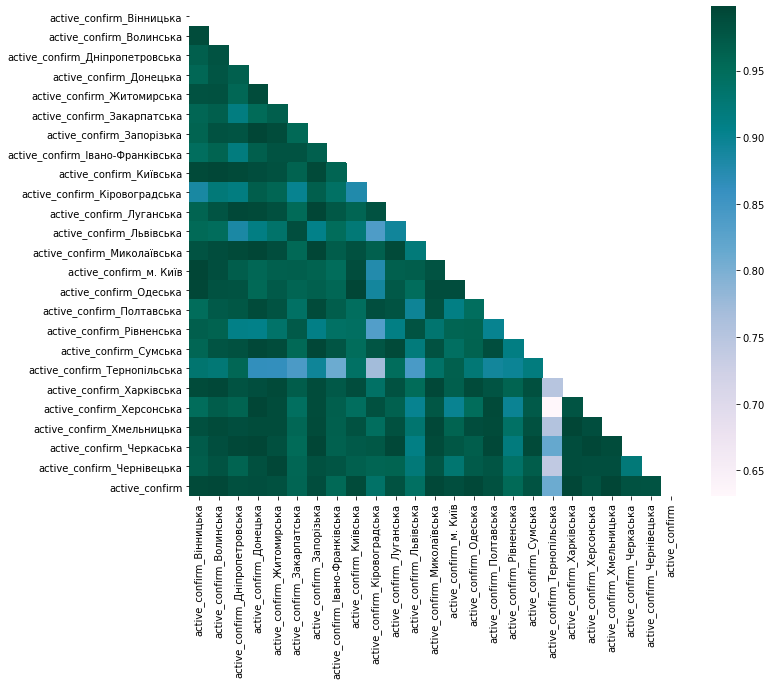

In [71]:
mask = np.triu(np.ones_like(table_1, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = 'PuBuGn'
sns.heatmap(table_1, mask=mask, cmap=cmap)

In [61]:
region_max = ma.tail(1).idxmax(axis='columns')
region_min = ma.tail(1).idxmin(axis='columns')
diff_rmax_rmin = ma[(region_max[-1])][-1] - ma[(region_min[-1])][-1]
print('Region-lider:\n',region_max[-1],'\n\nRegion-last\n', region_min[-1], '\n\nВідстає на\n', diff_rmax_rmin)

Region-lider:
 active_confirm_Харківська 

Region-last
 active_confirm_Кіровоградська 

Відстає на
 30598.0


In [69]:
def crosscorrt(data, datax, datay, lag):
    corrs = -1
    index = -1
    T = lag
    for i in range(abs(lag)+1):
        if i == 0:
            corrs = data[datax].corr(data[datay])
            index = 0
        else:
            cor = (data[datax].shift(i)).corr(data[datay])
            if cor > corrs:
                corrs = cor
                index = i
    return corrs, index

In [70]:

print(time.ctime())
ma = merge_areas()
col = ma.columns.tolist()
for i in col:
    for j in col:
        if i == j:
            table_1[j][i] = 1.0
            table_2[j][i] = 0
            break
        c = crosscorrt(ma, i, j, 30)
        table_2[j][i] = c[1]
        table_1[j][i] = c[0]
print(time.ctime())

Mon Nov 16 22:11:21 2020
Mon Nov 16 22:11:27 2020
